In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import f_oneway
from sklearn.feature_selection import f_regression
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the dataset
train = pd.read_csv('/Users/zionmicwu/Desktop/train.csv')
test = pd.read_csv('/Users/zionmicwu/Desktop/test.csv')
test_id = test.copy()

In [4]:
# Analyze missing values
mis_val = train.isnull().sum()
mis_val_percent = 100 * mis_val / len(train)
mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
mis_val_table.columns = ["Missing Values", "% of Total Values"]
print(mis_val_table[mis_val_table["Missing Values"] > 0].sort_values("% of Total Values", ascending=False))

              Missing Values  % of Total Values
PoolQC                  1453          99.520548
MiscFeature             1406          96.301370
Alley                   1369          93.767123
Fence                   1179          80.753425
MasVnrType               872          59.726027
FireplaceQu              690          47.260274
LotFrontage              259          17.739726
GarageType                81           5.547945
GarageYrBlt               81           5.547945
GarageFinish              81           5.547945
GarageQual                81           5.547945
GarageCond                81           5.547945
BsmtFinType2              38           2.602740
BsmtExposure              38           2.602740
BsmtFinType1              37           2.534247
BsmtCond                  37           2.534247
BsmtQual                  37           2.534247
MasVnrArea                 8           0.547945
Electrical                 1           0.068493


In [5]:
# Handle missing values
# Fill categorical columns with "None"
for col in ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "BsmtCond", "BsmtQual", "MasVnrType"]:
    train[col].fillna("None", inplace=True)
    test[col].fillna("None", inplace=True)

# Fill numerical columns logically
for col in ["GarageYrBlt", "GarageCars", "GarageArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea"]:
    train[col].fillna(0, inplace=True)
    test[col].fillna(0, inplace=True)

# Fill LotFrontage with median based on Neighborhood
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# Fill Electrical with mode
train["Electrical"].fillna(train["Electrical"].mode()[0], inplace=True)

# Verify remaining missing values
print("\nRemaining missing values in training data:")
print(train.isnull().sum().sum())
print("\nRemaining missing values in testing data:")
print(test.isnull().sum().sum())


Remaining missing values in training data:
0

Remaining missing values in testing data:
16


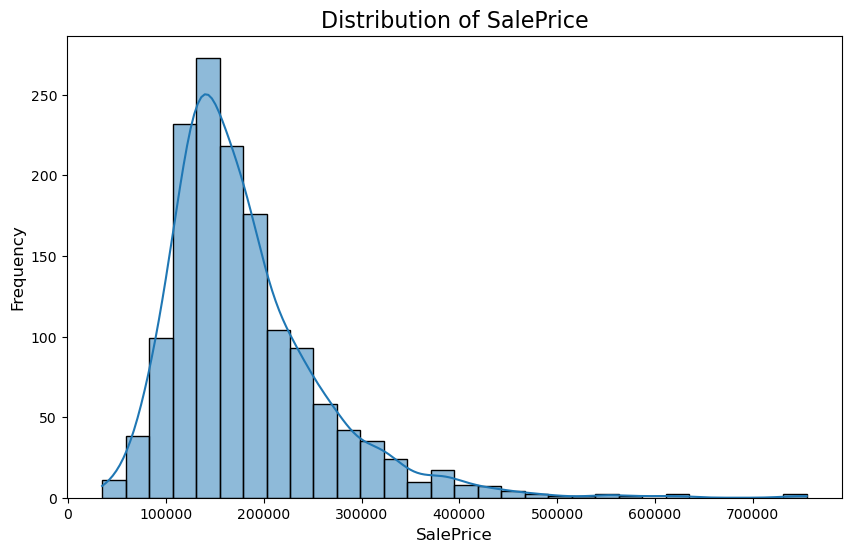

In [6]:
# Visualization: SalePrice distribution
plt.figure(figsize=(10, 6))
sns.histplot(train['SalePrice'], kde=True, bins=30)
plt.title("Distribution of SalePrice", fontsize=16)
plt.xlabel("SalePrice", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

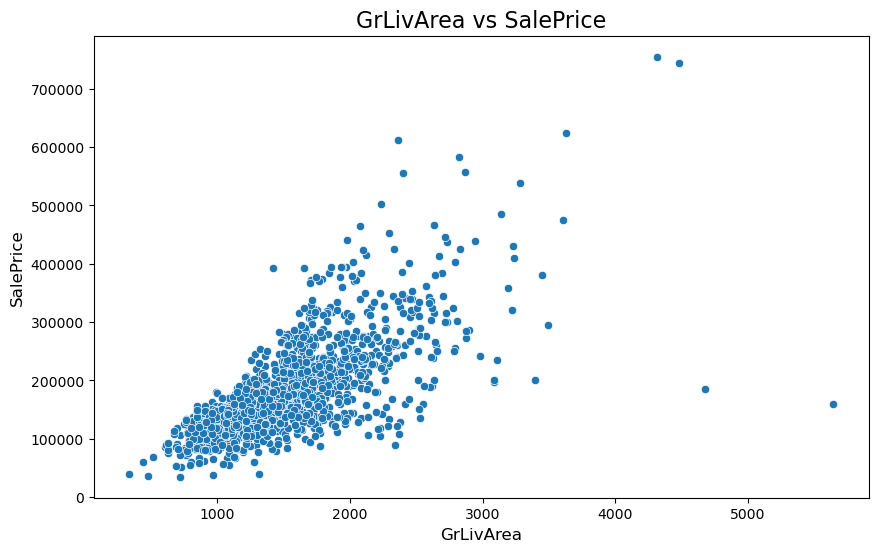

In [7]:
# Investigate outliers in GrLivArea vs. SalePrice
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train['GrLivArea'], y=train['SalePrice'])
plt.title("GrLivArea vs SalePrice", fontsize=16)
plt.xlabel("GrLivArea", fontsize=12)
plt.ylabel("SalePrice", fontsize=12)
plt.show()

In [8]:
# Identify and explore large houses with low prices
large_low_price = train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)]
print("\nLarge houses with low prices:\n", large_low_price)


Large houses with low prices:
         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
523    524          60       RL        130.0    40094   Pave  None      IR1   
1298  1299          60       RL        313.0    63887   Pave  None      IR3   

     LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
523          Bnk    AllPub  ...        0   None  None        None       0   
1298         Bnk    AllPub  ...      480     Gd  None        None       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
523      10   2007       New        Partial     184750  
1298      1   2008       New        Partial     160000  

[2 rows x 81 columns]


In [9]:
# Compare Edwards neighborhood vs overall prices
edwards_prices = train[train['Neighborhood'] == 'Edwards']['SalePrice']
print("\nEdwards Neighborhood Price Statistics:")
print(edwards_prices.describe())
print("\nOverall Price Statistics:")
print(train['SalePrice'].describe())


Edwards Neighborhood Price Statistics:
count       100.000000
mean     128219.700000
std       43208.616459
min       58500.000000
25%      101500.000000
50%      121750.000000
75%      145225.000000
max      320000.000000
Name: SalePrice, dtype: float64

Overall Price Statistics:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [10]:
# Add a new feature for house age
train['HouseAge'] = train['YrSold'] - train['YearBuilt']
test['HouseAge'] = test['YrSold'] - test['YearBuilt']

# Add HasFireplace feature
train['HasFireplace'] = (train['Fireplaces'] > 0).astype(bool)
test['HasFireplace'] = (test['Fireplaces'] > 0).astype(bool)

# Add Remodeled feature
train['Remodeled'] = (train['YearBuilt'] != train['YearRemodAdd']).astype(int)
test['Remodeled'] = (test['YearBuilt'] != test['YearRemodAdd']).astype(int)

# Add TotalBath feature
train['TotalBath'] = train['FullBath'] + 0.5 * train['HalfBath']
test['TotalBath'] = test['FullBath'] + 0.5 * test['HalfBath']

# Add TotalPorchArea feature
train['TotalPorchArea'] = train['OpenPorchSF'] + train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch']
test['TotalPorchArea'] = test['OpenPorchSF'] + test['EnclosedPorch'] + test['3SsnPorch'] + test['ScreenPorch']

# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features_train = poly.fit_transform(train[['GrLivArea', 'TotalBsmtSF']])
poly_features_test = poly.transform(test[['GrLivArea', 'TotalBsmtSF']])
poly_train_columns = poly.get_feature_names_out(['GrLivArea', 'TotalBsmtSF'])
poly_train_df = pd.DataFrame(poly_features_train, columns=poly_train_columns, index=train.index)
poly_train_df.drop(columns = ['GrLivArea', 'TotalBsmtSF'], inplace = True)
poly_test_df = pd.DataFrame(poly_features_test, columns=poly_train_columns, index=test.index)
poly_test_df.drop(columns = ['GrLivArea', 'TotalBsmtSF'], inplace = True)
train = pd.concat([train, poly_train_df], axis=1)
test = pd.concat([test, poly_test_df], axis=1)

# Drop used features
used_features = ["YearBuilt", "YearRemodAdd", "FullBath", "HalfBath", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"]
train.drop(columns=used_features, inplace=True)
test.drop(columns=used_features, inplace=True)

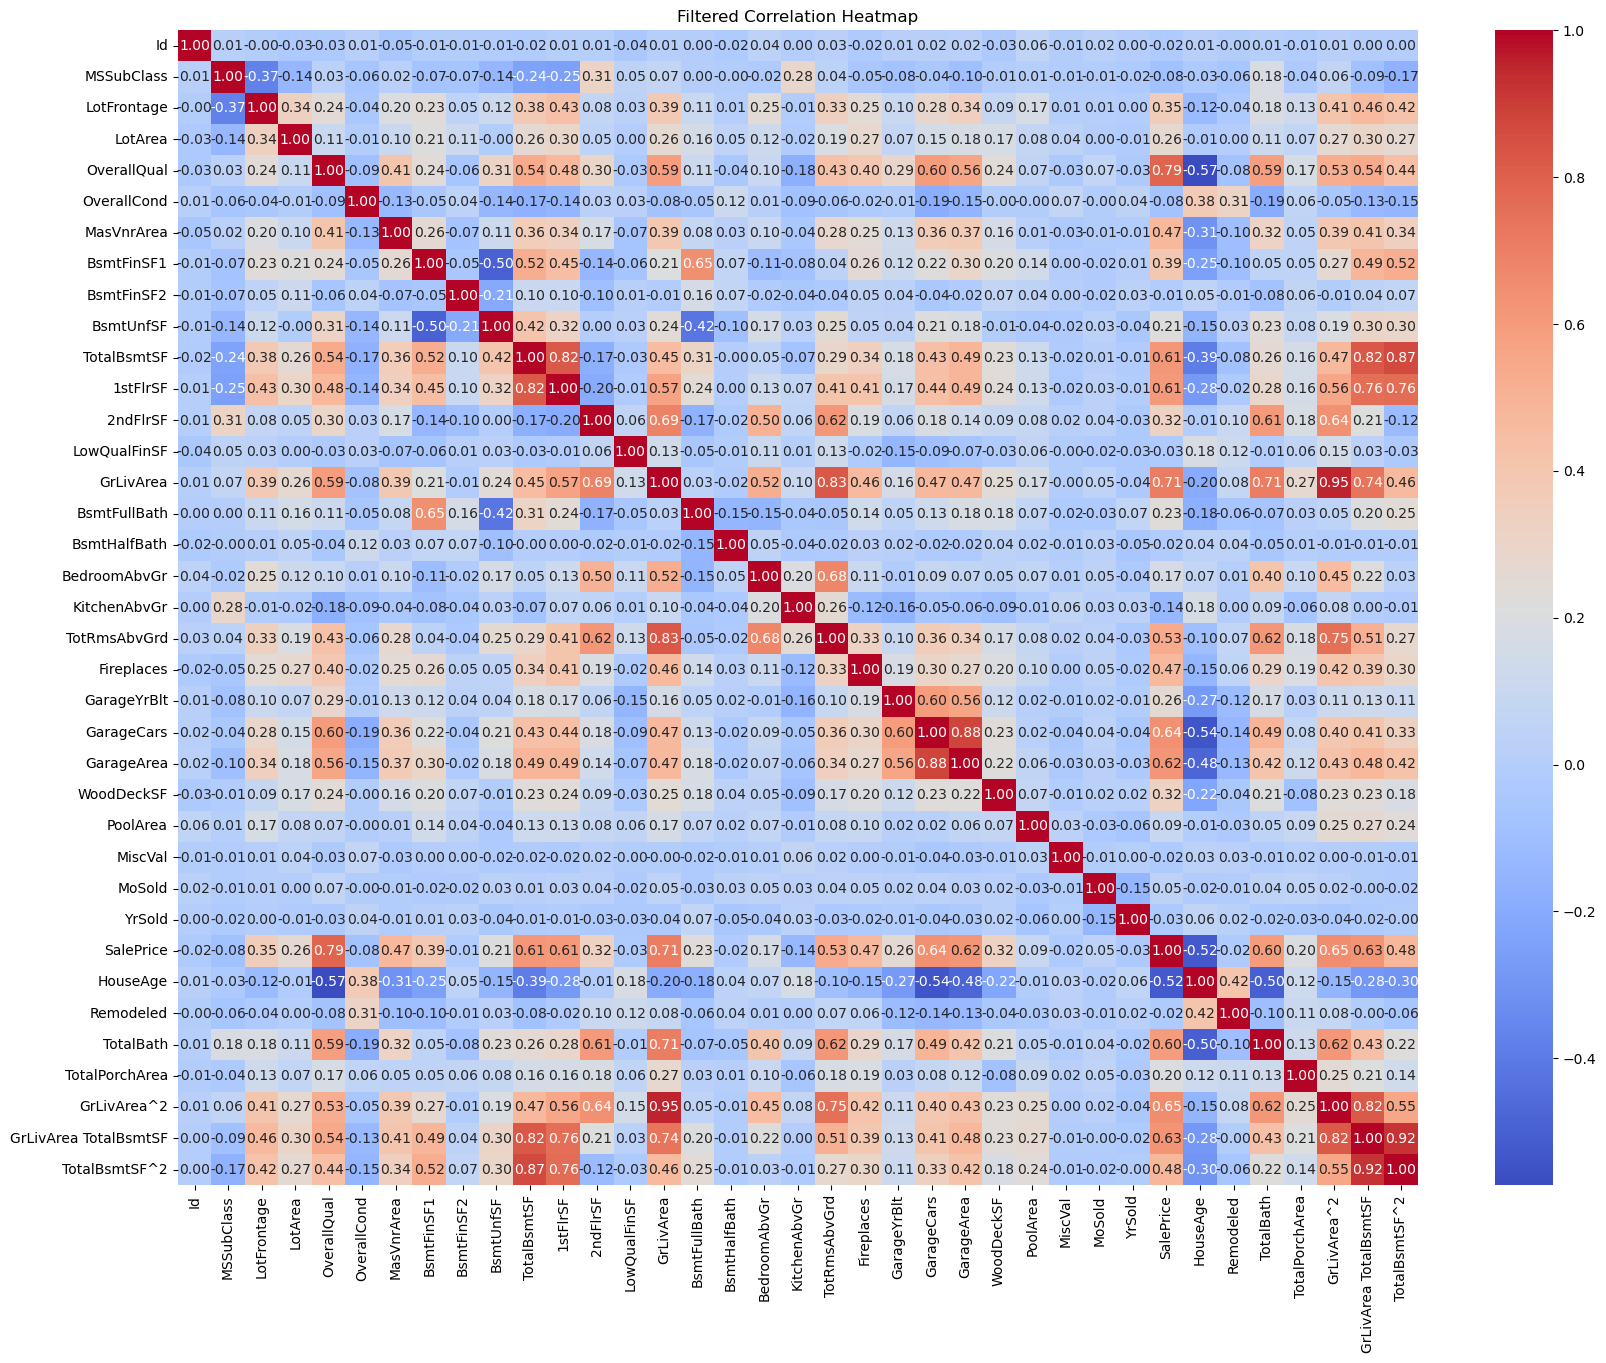

In [11]:
# Filter numeric columns for correlation matrix
numeric_columns = train.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = train[numeric_columns].corr()

# Plot filtered heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Filtered Correlation Heatmap")
plt.show()

In [12]:
# Calculate Variance Inflation Factor (VIF)
train_vif_copy = train[numeric_columns].copy()
train_vif_copy.drop(columns=['SalePrice'], inplace = True)
vif_data = pd.DataFrame()
vif_data['Feature'] = train_vif_copy.columns
vif_data['VIF'] = [variance_inflation_factor(train_vif_copy.values, i) for i in range(train_vif_copy.shape[1])]

print("VIF for each feature:")
print(vif_data)

# Shoe features with VIF > 10
high_vif_features = (vif_data[vif_data['VIF'] > 10]['Feature']).tolist()
print(high_vif_features)

VIF for each feature:
                  Feature         VIF
0                      Id    4.098068
1              MSSubClass    4.820569
2             LotFrontage   18.449923
3                 LotArea    2.678239
4             OverallQual   66.714354
5             OverallCond   35.746939
6              MasVnrArea    1.844395
7              BsmtFinSF1         inf
8              BsmtFinSF2         inf
9               BsmtUnfSF         inf
10            TotalBsmtSF         inf
11               1stFlrSF         inf
12               2ndFlrSF         inf
13           LowQualFinSF         inf
14              GrLivArea         inf
15           BsmtFullBath    3.831731
16           BsmtHalfBath    1.228016
17           BedroomAbvGr   31.397616
18           KitchenAbvGr   38.392844
19           TotRmsAbvGrd   84.093383
20             Fireplaces    2.944703
21            GarageYrBlt   32.528709
22             GarageCars   40.461190
23             GarageArea   31.564667
24             WoodDeckSF   

In [13]:
# Drop features with high collinearity
selected_high_vif_features = ['LotFrontage','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BedroomAbvGr', 'KitchenAbvGr', 'GarageYrBlt', 'YrSold']
train = train.drop(columns = selected_high_vif_features, errors = 'ignore')
test = test.drop(columns = selected_high_vif_features, errors = 'ignore')


In [14]:
# reFilter numeric columns for correlation matrix
numeric_columns = train.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = train[numeric_columns].corr()

# Filter only features with high correlation with SalePrice
correlation_threshold = 0.3
high_correlation_vars = correlation_matrix['SalePrice'][abs(correlation_matrix['SalePrice']) > correlation_threshold].index

# F-test for numerical feature selection
f_scores, p_values = f_regression(train[high_correlation_vars.drop('SalePrice')], train['SalePrice'])
f_test_results = pd.DataFrame({'Feature': high_correlation_vars.drop('SalePrice'), 'F-Score': f_scores, 'P-Value': p_values})
selected_num_features = f_test_results[f_test_results['P-Value'] < 0.05]['Feature'].tolist()
selected_num_features.append('SalePrice')

# Display selected features
print("\nSelected numerical features for regression:", selected_num_features)


Selected numerical features for regression: ['OverallQual', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'HouseAge', 'TotalBath', 'GrLivArea^2', 'GrLivArea TotalBsmtSF', 'TotalBsmtSF^2', 'SalePrice']


In [15]:
# Handle categorical variables
categorical_columns = train.select_dtypes(include=['object', 'category']).columns
print("Categorical Features:", len(categorical_columns))

train_copy = train.copy()

# Target encoding for correlation analysis
for col in categorical_columns:
    train_copy[f"{col}_encoded"] = train_copy.groupby(col)['SalePrice'].transform('mean')

# Correlation analysis
correlation = train_copy[[f"{col}_encoded" for col in categorical_columns] + ['SalePrice']].corr()
print("Correlation with SalePrice:")
print(correlation['SalePrice'].sort_values(ascending=False))

# ANOVA for significance testing
for col in categorical_columns:
    groups = [group['SalePrice'].values for name, group in train.groupby(col)]
    anova_result = f_oneway(*groups)
    print(f"{col}: p-value = {anova_result.pvalue}")

# Filter based on correlation and p-value thresholds
selected_cat_features = [
    col for col in categorical_columns
    if correlation[f"{col}_encoded"]["SalePrice"] > 0.3
    and f_oneway(*[group['SalePrice'].values for name, group in train.groupby(col)]).pvalue < 0.05
]
print("Important categorical features:", selected_cat_features) 

Categorical Features: 43
Correlation with SalePrice:
SalePrice                1.000000
Neighborhood_encoded     0.738630
ExterQual_encoded        0.690933
BsmtQual_encoded         0.681905
KitchenQual_encoded      0.675721
GarageFinish_encoded     0.553059
FireplaceQu_encoded      0.542181
Foundation_encoded       0.506328
GarageType_encoded       0.499204
BsmtFinType1_encoded     0.459141
HeatingQC_encoded        0.442154
MasVnrType_encoded       0.428108
Exterior2nd_encoded      0.392211
Exterior1st_encoded      0.390862
BsmtExposure_encoded     0.386653
SaleType_encoded         0.370523
SaleCondition_encoded    0.368100
MSZoning_encoded         0.327963
HouseStyle_encoded       0.293790
GarageQual_encoded       0.285344
GarageCond_encoded       0.285213
LotShape_encoded         0.276362
CentralAir_encoded       0.251328
Electrical_encoded       0.244235
RoofStyle_encoded        0.240201
PavedDrive_encoded       0.233537
BsmtCond_encoded         0.226706
Fence_encoded            0.18

In [16]:
# Update the datasets after selection
train = train[selected_num_features + selected_cat_features]
selected_num_features.remove('SalePrice')
test = test[selected_num_features + selected_cat_features]

# Create dummy variables for important categorical features
train = pd.get_dummies(train, columns=selected_cat_features, drop_first=True)
test = pd.get_dummies(test, columns=selected_cat_features, drop_first=True)

# Convert a Boolean value to a numeric value
train = train.astype(int)
test = test.astype(int)

# Align train and test datasets
train, test = train.align(test, join='left', axis=1)
test.fillna(0, inplace=True)

# Prepare data for modeling
X = train.drop(columns=['SalePrice'])
y = np.log1p(train['SalePrice'])  # log transformation

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply scaling

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
test_scaled = test.copy()
scaler = StandardScaler()
X_train_scaled[selected_num_features] = scaler.fit_transform(X_train[selected_num_features])
X_val_scaled[selected_num_features] = scaler.transform(X_val[selected_num_features])
test_scaled[selected_num_features] = scaler.transform(test[selected_num_features])
test_scaled.drop(columns = ['SalePrice'], inplace = True)

Linear Regression MSE: 9.438032194376308e+19
Linear Regression R2: -5.0575972324767295e+20


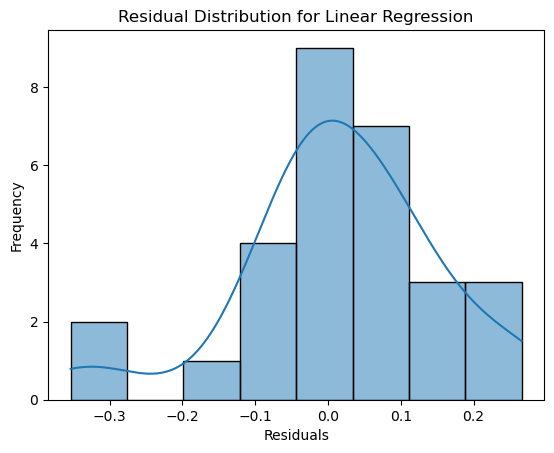

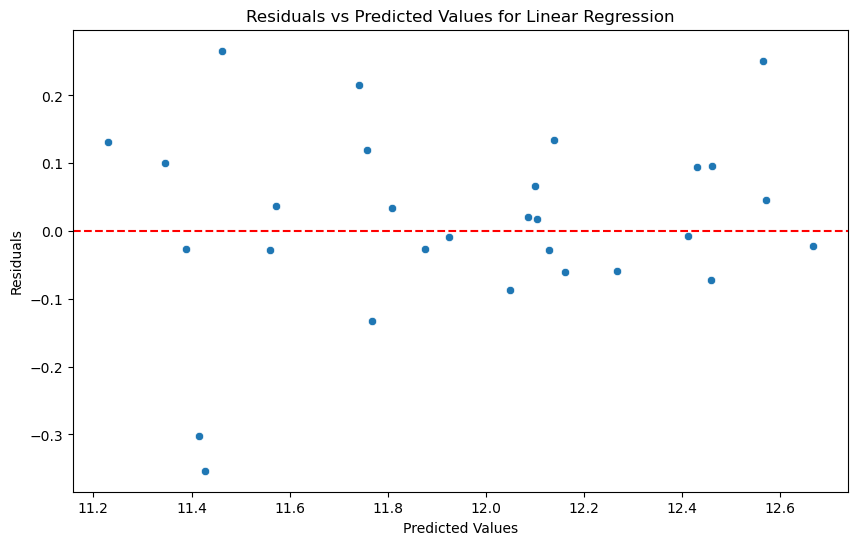

Durbin-Watson Statistic: 2.642248513887876


In [17]:
# Model 1: Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
linear_preds = linear_model.predict(X_val_scaled)

# Evaluate Linear Regression
linear_mse = mean_squared_error(y_val, linear_preds)
linear_r2 = r2_score(y_val, linear_preds)
print("Linear Regression MSE:", linear_mse)
print("Linear Regression R2:", linear_r2)

# Residual analysis for Linear Regression
sample_index = np.random.choice(len(y_val), size=int(0.1 * len(y_val)), replace=False)
sample_linear_preds = linear_preds[sample_index]
residuals_linear = (y_val.iloc[sample_index] - sample_linear_preds)

# Residual normality
sns.histplot(residuals_linear, kde=True)
plt.title("Residual Distribution for Linear Regression")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Residual Homoscedasticity
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sample_linear_preds, y=residuals_linear)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values for Linear Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# Residual independence
dw_stat = durbin_watson(residuals_linear)
print(f"Durbin-Watson Statistic: {dw_stat}")

Fold 1: RMSE = 0.1149
Fold 1: R2 = 0.9151
Fold 2: RMSE = 0.1309
Fold 2: R2 = 0.9274
Fold 3: RMSE = 0.1368
Fold 3: R2 = 0.8956
Fold 4: RMSE = 0.1375
Fold 4: R2 = 0.8915
Fold 5: RMSE = 0.1056
Fold 5: R2 = 0.9061
Fold 6: RMSE = 0.1400
Fold 6: R2 = 0.8688
Fold 7: RMSE = 0.1650
Fold 7: R2 = 0.8569
Fold 8: RMSE = 0.1390
Fold 8: R2 = 0.8802
Fold 9: RMSE = 0.0968
Fold 9: R2 = 0.9260
Fold 10: RMSE = 0.1914
Fold 10: R2 = 0.7769
Fold 11: RMSE = 0.1479
Fold 11: R2 = 0.8093
Fold 12: RMSE = 0.1478
Fold 12: R2 = 0.8575
Fold 13: RMSE = 0.1482
Fold 13: R2 = 0.9181
Fold 14: RMSE = 0.1272
Fold 14: R2 = 0.8922
Fold 15: RMSE = 0.1338
Fold 15: R2 = 0.8703
Fold 16: RMSE = 0.1404
Fold 16: R2 = 0.8611
Fold 17: RMSE = 0.1325
Fold 17: R2 = 0.8817
Fold 18: RMSE = 0.1527
Fold 18: R2 = 0.8223
Fold 19: RMSE = 0.0958
Fold 19: R2 = 0.9162
Fold 20: RMSE = 0.1204
Fold 20: R2 = 0.9041


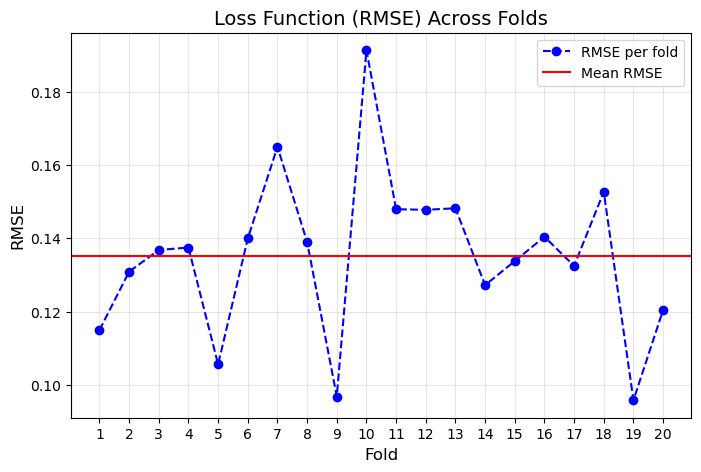

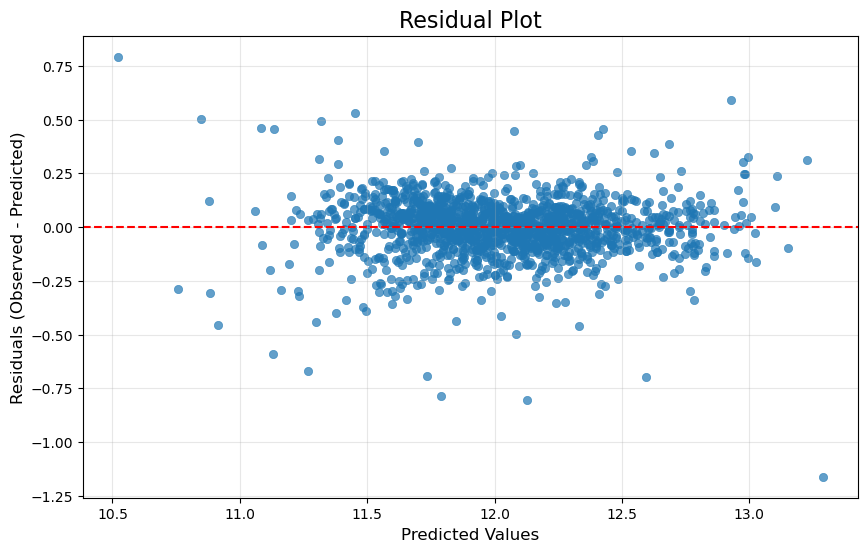

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     108.8
Date:                Wed, 29 Jan 2025   Prob (F-statistic):               0.00
Time:                        03:59:00   Log-Likelihood:                 1043.2
No. Observations:                1460   AIC:                            -1830.
Df Residuals:                    1332   BIC:                            -1154.
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.41

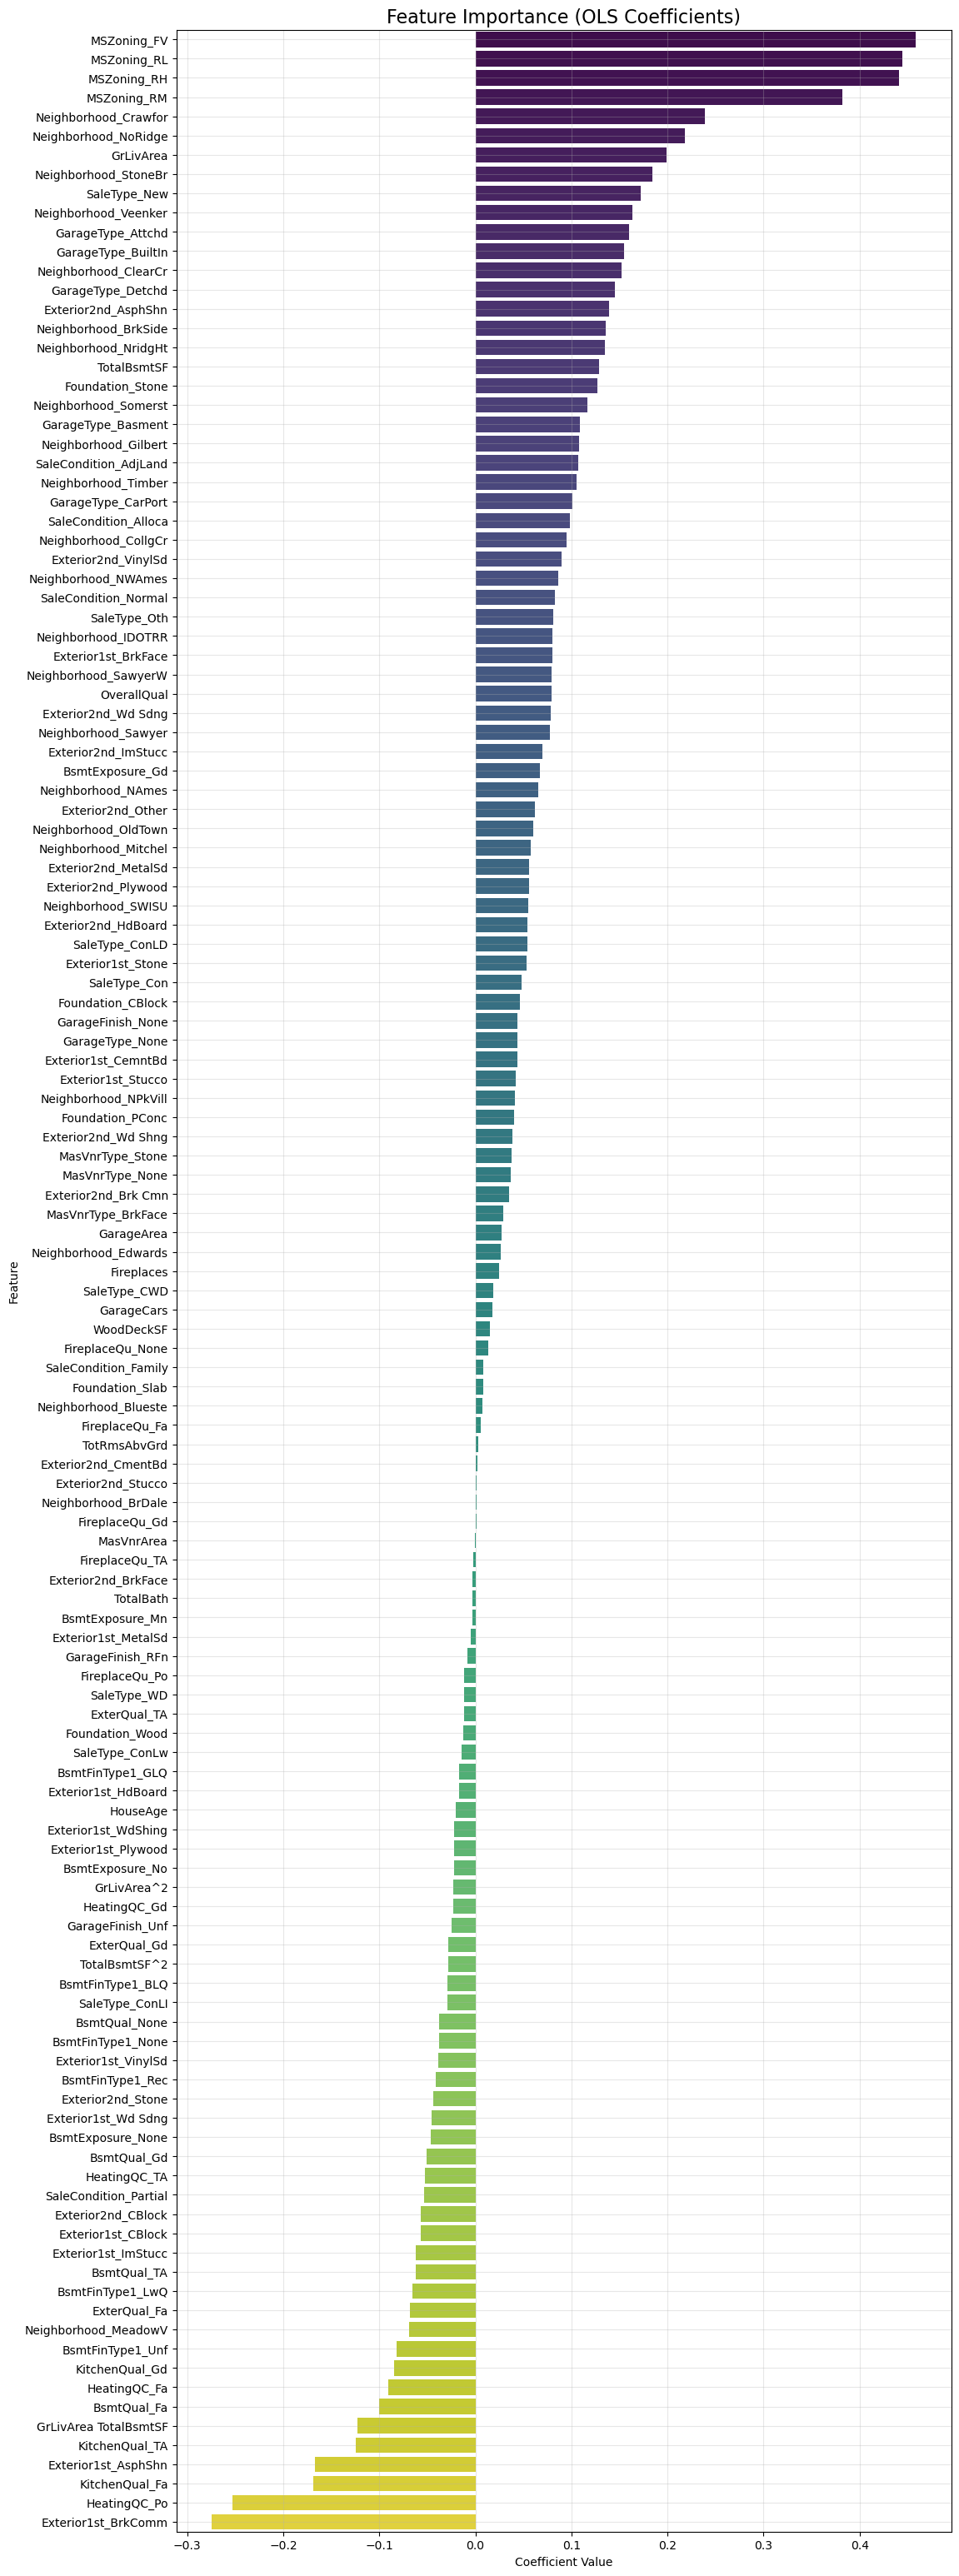

Mean RMSE: 0.1352205598606172
Fold RMSEs: [0.11491628999747724, 0.13089324894671112, 0.13680350534315486, 0.13748157001002845, 0.10557397323743635, 0.13995219393332659, 0.1649903215336288, 0.13898748364882807, 0.09678305401035807, 0.1913661124976918, 0.14794618660399353, 0.14777697106089666, 0.14820973941577, 0.12720841356478443, 0.13376718734790097, 0.14042225418591261, 0.1324604548653019, 0.15269142959054324, 0.09577750982366161, 0.12040329759493856]


In [18]:
# Model 2: OLS

def ols_with_cross_validation_and_loss_plot(X, y, n_splits):
    """
    Perform OLS regression with k-fold cross-validation, feature importance visualization,
    and graph the loss function across folds.

    Parameters:
    X (pd.DataFrame): Feature matrix.
    y (pd.Series): Target vector.
    n_splits (int): Number of folds for cross-validation.

    Returns:
    dict: Cross-validation metrics and feature importance plot.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_rmse = []
    fold_r2 = []

    residuals = []  # To store residuals for all folds
    predictions = []  # To store predictions for all folds
    actuals = []  # To store actual values for all folds

    # Apply scaling
    scaler = StandardScaler()
    X[selected_num_features] = scaler.fit_transform(X[selected_num_features])

    for fold_idx, (train_index, test_index) in enumerate(kf.split(X), start=1):
        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Add a constant for the intercept
        X_train_const = sm.add_constant(X_train, has_constant="add")

        X_test_const = sm.add_constant(X_test, has_constant="add")

        # Fit the OLS model
        ols_model = sm.OLS(y_train, X_train_const).fit()

        # Predict on the validation set
        y_pred = ols_model.predict(X_test_const)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        fold_rmse.append(rmse)

        # Calculate R squared
        r2 = r2_score(y_test, y_pred)
        fold_r2.append(r2)
        
        # Store residuals and predictions
        residuals.extend(y_test - y_pred)
        predictions.extend(y_pred)
        actuals.extend(y_test)

        # Print the fold RMSE
        print(f"Fold {fold_idx}: RMSE = {rmse:.4f}")
        print(f"Fold {fold_idx}: R2 = {r2:.4f}")

    # Plot the loss function across folds
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, n_splits + 1), fold_rmse, marker='o', linestyle='--', color='b', label='RMSE per fold')
    plt.axhline(np.mean(fold_rmse), color='r', linestyle='-', label='Mean RMSE')
    plt.title('Loss Function (RMSE) Across Folds', fontsize=14)
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.xticks(range(1, n_splits + 1))
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

     # Plot Residuals
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=predictions, y=residuals, alpha=0.7, edgecolor=None)
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Residual Plot', fontsize=16)
    plt.xlabel('Predicted Values', fontsize=12)
    plt.ylabel('Residuals (Observed - Predicted)', fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

    # Train the final OLS model on the full dataset
    X_const = sm.add_constant(X)
    final_model = sm.OLS(y, X_const).fit()

    # Print the OLS summary
    print(final_model.summary())

    # Create coefficients DataFrame
    coefficients = pd.DataFrame({
        "Feature": X.columns,
        "Coefficient Estimate": final_model.params[1:]  # Exclude the intercept
    }).sort_values(by="Coefficient Estimate", ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, len(coefficients) * 0.3))
    sns.barplot(x="Coefficient Estimate", y="Feature", data=coefficients, palette="viridis")
    plt.title("Feature Importance (OLS Coefficients)", fontsize=16)
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.grid(alpha=0.3)
    plt.show()

    return {
        "mean_rmse": np.mean(fold_rmse),
        "fold_rmse": fold_rmse,
        "final_model": final_model
    }

# Run OLS with cross-validation and loss function plot on the diabetes dataset
results = ols_with_cross_validation_and_loss_plot(X, y, n_splits=20)
print("Mean RMSE:", results["mean_rmse"]) 
print("Fold RMSEs:", results["fold_rmse"])

In [19]:
# Predictions for test set
test_scaled_const = sm.add_constant(test_scaled, has_constant="add")
test_preds = results['final_model'].predict(test_scaled_const)
test_preds_exp = np.expm1(test_preds)  # exp(test_preds_log) - 1

# Save predictions to CSV
submission = pd.DataFrame({
    'Id': test_id['Id'],
    'SalePrice': test_preds_exp
})
submission.to_csv('submission.csv', index=False)